In [38]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.models import load_model
import cv2
from tensorflow.keras.models import Model

In [39]:
items = os.listdir('dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

In [40]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {}
        for dog_category in dog_categories:
                self._data[dog_category] = {
                        'vrai positif': 0,
                        'faux positif': 0,
                        'precision':0
                    }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test, verbose=0))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                if test == prediction:
                    self._data[dog_categories[test]]['vrai positif'] = self._data[dog_categories[test]]['vrai positif'] + 1
                if test != prediction:
                    self._data[dog_categories[prediction]]['faux positif'] = self._data[dog_categories[prediction]]['faux positif'] + 1
        return

    def get_data(self):
        for data in self._data:
            self._data[data]['precision'] = self._data[data]['vrai positif'] / (self._data[data]['vrai positif'] + self._data[data]['faux positif'])
        return self._data

In [41]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Je charge mes datasets

In [42]:
BATCH_SIZE = 32
IMG_SIZE = 224
NB_CLASS = 122
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 16545 files belonging to 122 classes.
Found 1234 files belonging to 122 classes.
Found 5931 files belonging to 122 classes.


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classe en one hot

In [44]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))

In [77]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.3)
])


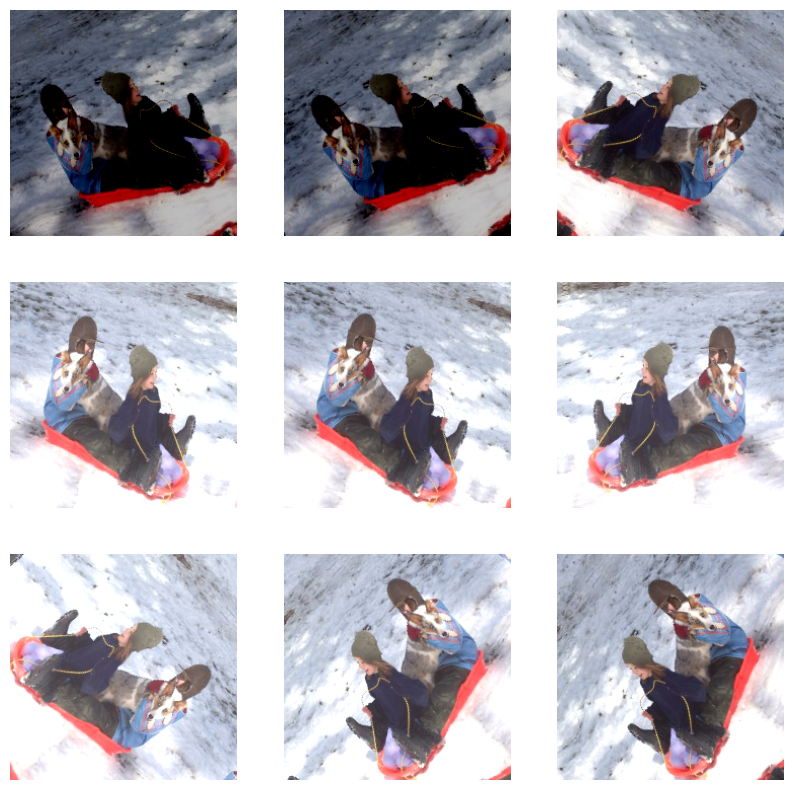

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Utilisation de mobilenet v2

In [82]:
base_model = keras.applications.ResNet50V2(
                        include_top=False, # Exclude ImageNet classifier at the top
                        weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)
                        )

In [83]:
base_model.trainable = False
# base_model.summary()

Pour générer des prédictions à partir du bloc d'entités, effectuez une moyenne sur les emplacements spatiaux 5x5 , à l'aide d'une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les entités en un seul vecteur de 1 280 éléments par image.

On construit le modèle

In [84]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.GaussianNoise(stddev=0.2)(x)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(NB_CLASS, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model = keras.Model(inputs, outputs)

In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [14]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [15]:
metrics = Metrics(val_data = validation_dataset, dog_categories = dog_categories)

In [16]:
EPOCHS = 25

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    verbose=1,
                    callbacks =[earlystopping, metrics])

Epoch 1/25
518/518 [==============================] - 190s 358ms/step - loss: 2.0384 - categorical_accuracy: 0.5038 - val_loss: 0.9337 - val_categorical_accuracy: 0.7297
Epoch 2/25
518/518 [==============================] - 183s 354ms/step - loss: 1.3461 - categorical_accuracy: 0.6432 - val_loss: 0.8824 - val_categorical_accuracy: 0.7422
Epoch 3/25
518/518 [==============================] - 183s 353ms/step - loss: 1.1751 - categorical_accuracy: 0.6806 - val_loss: 0.9101 - val_categorical_accuracy: 0.7466
Epoch 4/25
518/518 [==============================] - 182s 352ms/step - loss: 1.0731 - categorical_accuracy: 0.7040 - val_loss: 0.9184 - val_categorical_accuracy: 0.7469
Epoch 5/25
518/518 [==============================] - 183s 353ms/step - loss: 0.9919 - categorical_accuracy: 0.7228 - val_loss: 0.9345 - val_categorical_accuracy: 0.7419
Epoch 6/25
518/518 [==============================] - 186s 359ms/step - loss: 0.9627 - categorical_accuracy: 0.7301 - val_loss: 0.9119 - val_categoric

In [17]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 147,
  'faux positif': 65,
  'precision': 0.6933962264150944},
 'Japanese_spaniel': {'vrai positif': 274,
  'faux positif': 23,
  'precision': 0.9225589225589226},
 'Maltese_dog': {'vrai positif': 394,
  'faux positif': 134,
  'precision': 0.7462121212121212},
 'Pekinese': {'vrai positif': 174,
  'faux positif': 80,
  'precision': 0.6850393700787402},
 'Shih': {'vrai positif': 200,
  'faux positif': 129,
  'precision': 0.60790273556231},
 'Blenheim_spaniel': {'vrai positif': 276,
  'faux positif': 39,
  'precision': 0.8761904761904762},
 'papillon': {'vrai positif': 297,
  'faux positif': 54,
  'precision': 0.8461538461538461},
 'toy_terrier': {'vrai positif': 198,
  'faux positif': 138,
  'precision': 0.5892857142857143},
 'Rhodesian_ridgeback': {'vrai positif': 182,
  'faux positif': 155,
  'precision': 0.5400593471810089},
 'Afghan_hound': {'vrai positif': 368,
  'faux positif': 54,
  'precision': 0.8720379146919431},
 'basset': {'vrai positif': 222,
 

In [18]:
loss0, accuracy0 = model.evaluate(test_dataset)

39/39 [==============================] - 3s 71ms/step - loss: 0.9351 - categorical_accuracy: 0.7415


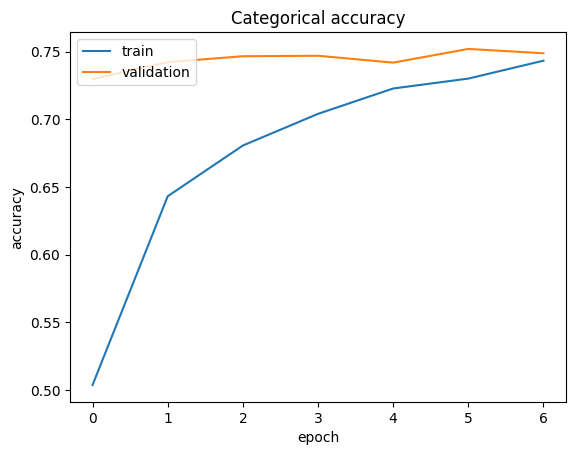

In [19]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [20]:
model.save('Modele_transfert.h5')

In [21]:
model = load_model('Modele_transfert.h5')

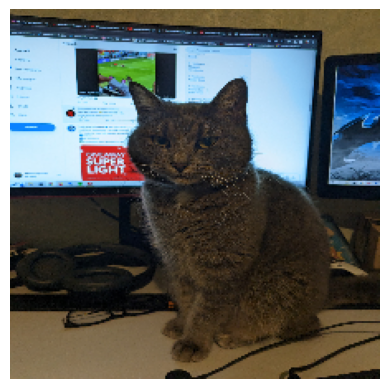

In [29]:
# image = cv2.imread('Train_Test_Folder/test/n02090622-borzoi/n02090622_3586.jpg')
image = cv2.imread('PXL_20221215_220803601.MP.jpg')
new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
plt.axis('off')
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
img = np.expand_dims(cv2.resize(image,(IMG_SIZE, IMG_SIZE)), axis=0)
y_predict = np.asarray(model.predict(img, verbose=0))
pred = np.argmax(y_predict, axis=1)
print(dog_categories[pred[0]])

schipperke


In [24]:
def display_image_filtered(name_image,model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1)  
    img=cv2.resize(image,(IMG_SIZE,IMG_SIZE))              
    input_img= np.expand_dims(img, axis=0)      
    f=feature_map_1.predict(input_img) 
    dim = f.shape[1]
    print(dim)
    print(f'{layer_name} | Features Shape: {f.shape}')
    
    fig= plt.figure(figsize=(30,30))
    
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')        
    for i in range(dim):
        ax = fig.add_subplot(int(dim), int(dim),i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i])
        # plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg',f[0,:,:,i])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

1/1 [==============================] - 0s 40ms/step
56
conv2_block1_0_conv | Features Shape: (1, 56, 56, 256)
1/1 [==============================] - 0s 87ms/step
56
conv2_block2_1_conv | Features Shape: (1, 56, 56, 64)
1/1 [==============================] - 0s 140ms/step
28
conv3_block1_2_conv | Features Shape: (1, 28, 28, 128)
1/1 [==============================] - 0s 222ms/step
14
conv4_block1_0_conv | Features Shape: (1, 14, 14, 1024)
1/1 [==============================] - 1s 632ms/step
14
conv4_block5_2_conv | Features Shape: (1, 14, 14, 256)
1/1 [==============================] - 0s 398ms/step
7
conv5_block2_1_conv | Features Shape: (1, 7, 7, 512)


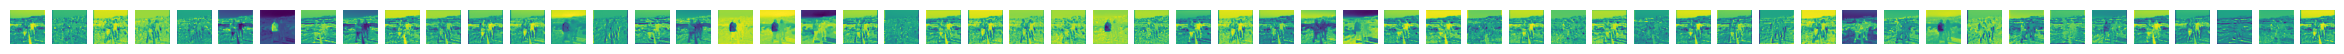

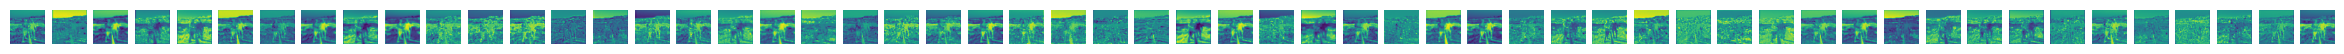

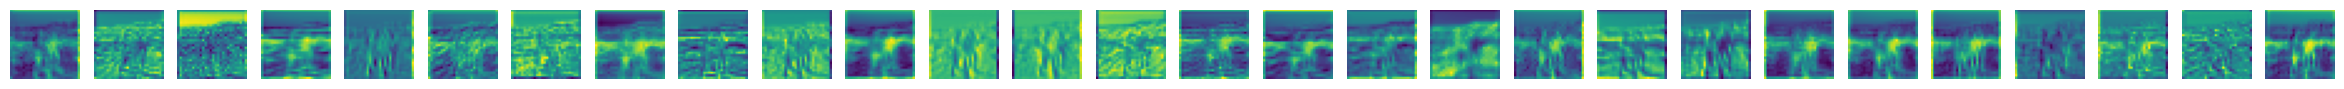

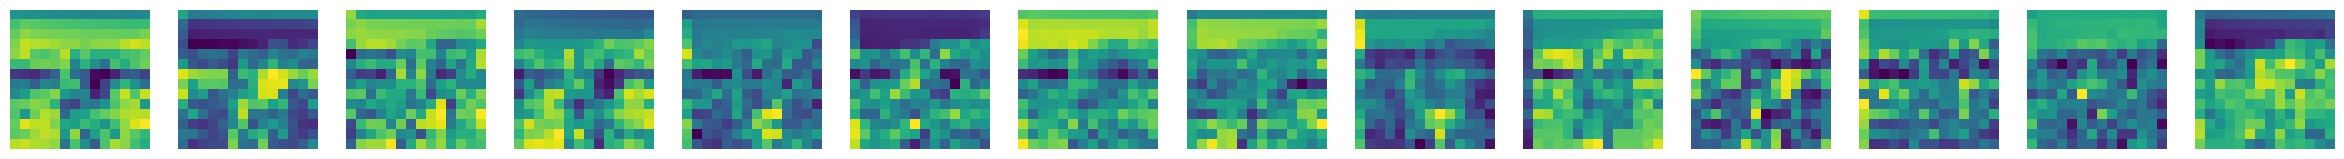

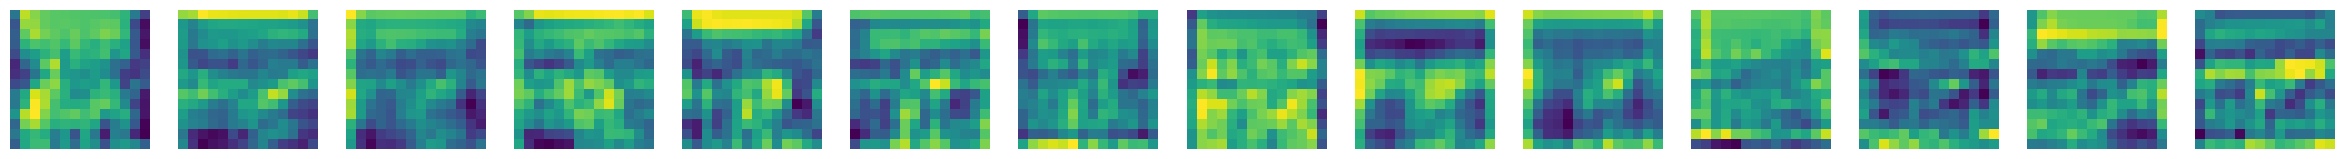

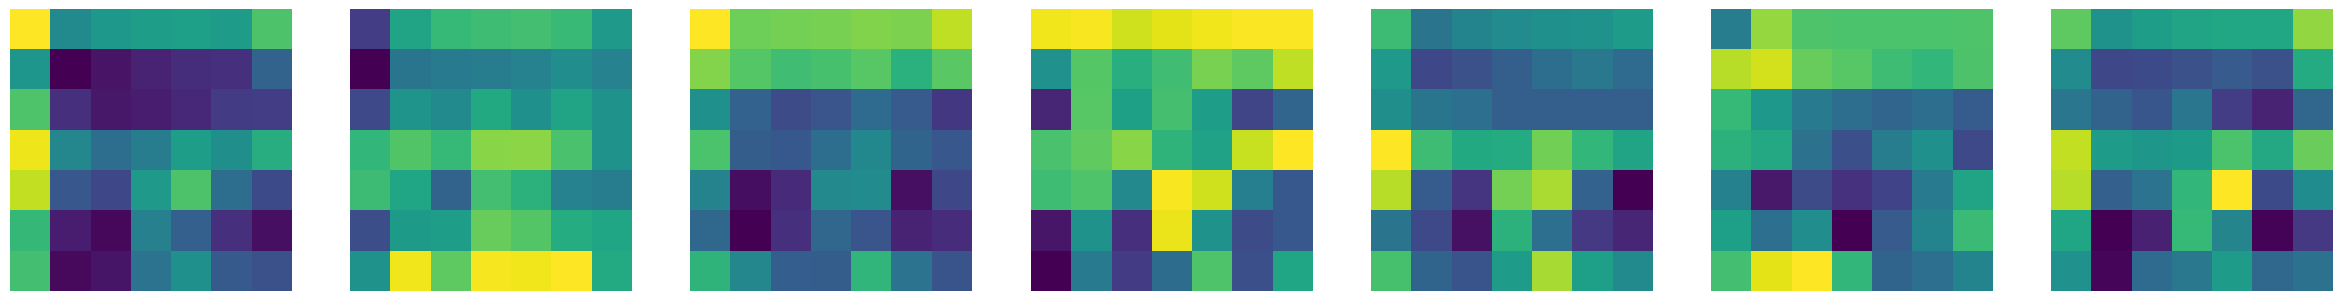

In [26]:
display_image_filtered('test', base_model, f'conv2_block1_0_conv', new_image)
display_image_filtered('test', base_model, f'conv2_block2_1_conv', new_image)  
display_image_filtered('test', base_model, f'conv3_block1_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv4_block1_0_conv', new_image) 
display_image_filtered('test', base_model, f'conv4_block5_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv5_block2_1_conv', new_image) 